#  Project: Patient Visit Forecasting (2019–2021)

## ✅ Requirements Fulfilled in This Notebook

This project meets all key requirements for time series forecasting and comparative analysis:

- ✅ Load and preprocess a multi-year, weekly dataset of patient visits
- ✅ Perform Exploratory Data Analysis (EDA) to uncover trends and seasonality
- ✅ Apply Triple Exponential Smoothing (Holt-Winters) for forecasting
- ✅ Use ARIMA and SARIMA models to capture trend/seasonality
- ✅ Implement and compare multiple ML models:
  - Random Forest, Gradient Boosting, AdaBoost  
  - Linear Regression, SVR, KNN, Decision Tree  
  - XGBoost (conditionally if available)
- ✅ Split data into train/test sets for evaluation
- ✅ Compute accuracy metrics (RMSE, MAE, MAPE)
- ✅ Visualize actual vs. predicted forecasts
- ✅ Identify and recommend the best model based on lowest RMSE
- ✅ Designed to run in Jupyter/Kaggle environments with flexible file paths

---

## 📁 1. Load Dataset

- Loads Excel data from multiple path options (Kaggle and local)
- Checks for the file's existence to avoid errors

---

##  2. Preprocessing

- Sorts data chronologically by **Year** and **Week**
- Creates a continuous `Time_Index` with weekly frequency
- Sets the time index as the DataFrame index
- Extracts the `Patient_Visits` time series for forecasting

---

##  3. Exploratory Data Analysis (EDA)

### 3.1 Trend Line
- Shows weekly patient visit patterns over time to detect trends

### 3.2 Distribution Histogram
- Illustrates the overall distribution of visit counts

### 3.3 Staff vs. Visits Correlation
- Scatterplot to visualize staff impact on patient visits

### 3.4 Average Visits by Week Number
- Highlights seasonal trends across years

### 3.5 Monthly Boxplot
- Shows month-wise variation in visits to capture seasonality

---

##  4. Train/Test Split

- Splits the data into training and testing sets (last 12 weeks as test)
- Converts week indices into numeric format for ML models

---

##  5. Evaluation Metrics

Three key metrics are used to evaluate each model:

- **RMSE**: Root Mean Squared Error  
- **MAE**: Mean Absolute Error  
- **MAPE**: Mean Absolute Percentage Error  

These metrics measure prediction error on the test set.

---

##  6. Model Training & Forecasting

### 📊 Statistical Models
- **Holt-Winters**: Triple Exponential Smoothing with additive seasonality  
- **ARIMA (2,1,2)**: Captures trend and short-term dependencies  
- **SARIMA (1,1,1)(1,1,1,52)**: Adds seasonal components to ARIMA (weekly seasonality)

###  Machine Learning Models
All ML models are trained on numerical week indices:

- Random Forest  
- Gradient Boosting  
- XGBoost (conditionally imported)  
- Linear Regression  
- Support Vector Regressor (SVR)  
- K-Nearest Neighbors (KNN)  
- Decision Tree  
- AdaBoost

---

##  7. Forecast Visualization

- Plots actual patient visits and overlayed model forecasts
- Color-coded lines make comparison easy across models

---

##  8. Accuracy Summary Table

- Displays and compares **RMSE**, **MAE**, and **MAPE** across all models
- Sorts results by **RMSE** to highlight the most accurate model
- Recommends the **best-performing model** based on metrics

---

##  Final Output

A printed summary shows:

- Forecast accuracy of all models  
- The **recommended model** with the **best RMSE**


In [28]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/covide-dataset/CVS_COVID_Forecasting_Data_2019_2021_With_Locations_Staff.xlsx


In [29]:
import warnings
warnings.filterwarnings('ignore')

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Try to import XGBoost; if unavailable, skip
try:
    from xgboost import XGBRegressor
    xgb_available = True
except ImportError:
    xgb_available = False

In [30]:
# =============================================================================
# 1. Load Dataset
# =============================================================================
file_paths = [
    "/kaggle/input/covide-dataset/CVS_COVID_Forecasting_Data_2019_2021_With_Locations_Staff.xlsx",
    "/mnt/data/CVS_COVID_Forecasting_Data_2019_2021_With_Locations_Staff.xlsx"
]
for fp in file_paths:
    if os.path.exists(fp):
        file_path = fp
        break
else:
    raise FileNotFoundError("Dataset not found in expected locations.")

df = pd.read_excel(file_path)


In [31]:
# =============================================================================
# 2. Preprocessing
# =============================================================================
df = df.sort_values(by=["Year", "Week"]).reset_index(drop=True)
df["Time_Index"] = pd.date_range(start="2019-01-01", periods=len(df), freq="W")
df = df.set_index("Time_Index")
ts = df["Patient_Visits"]

In [32]:
# =============================================================================
# 3. Exploratory Data Analysis (EDA)
# =============================================================================
def show_plot():
    plt.tight_layout()
    plt.show()

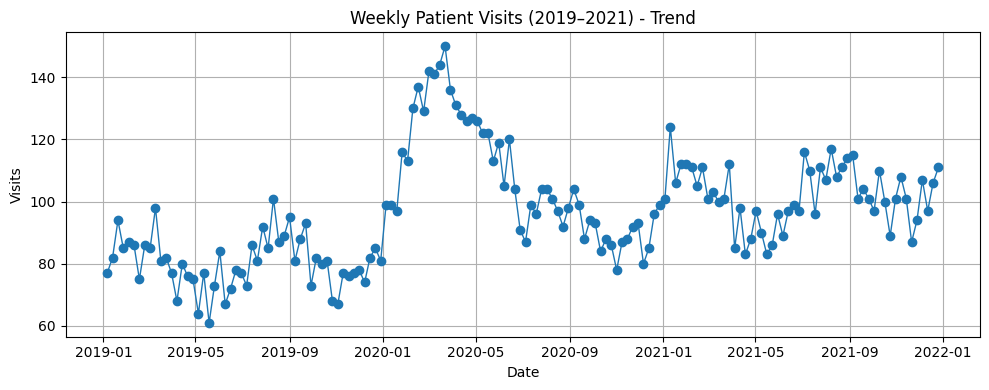

In [33]:
# 3.1 Trend
plt.figure(figsize=(10,4))
plt.plot(ts.index, ts, marker="o", linewidth=1)
plt.title("Weekly Patient Visits (2019–2021) - Trend")
plt.xlabel("Date"); plt.ylabel("Visits"); plt.grid(True)
show_plot()


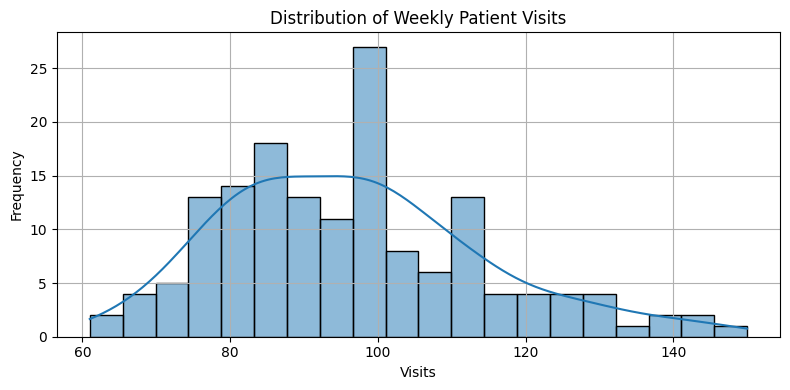

In [34]:
# 3.2 Distribution
plt.figure(figsize=(8,4))
sns.histplot(ts, bins=20, kde=True, edgecolor="k")
plt.title("Distribution of Weekly Patient Visits")
plt.xlabel("Visits"); plt.ylabel("Frequency"); plt.grid(True)
show_plot()

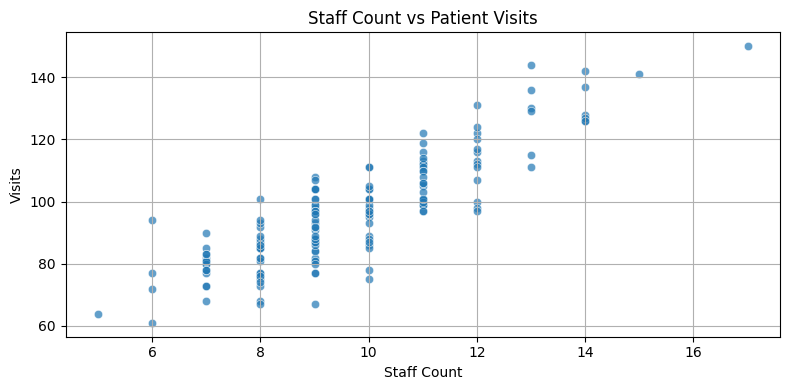

In [35]:

# 3.3 Staff vs Visits
plt.figure(figsize=(8,4))
sns.scatterplot(x=df["Staff_Count"], y=ts, alpha=0.7)
plt.title("Staff Count vs Patient Visits")
plt.xlabel("Staff Count"); plt.ylabel("Visits"); plt.grid(True)
show_plot()

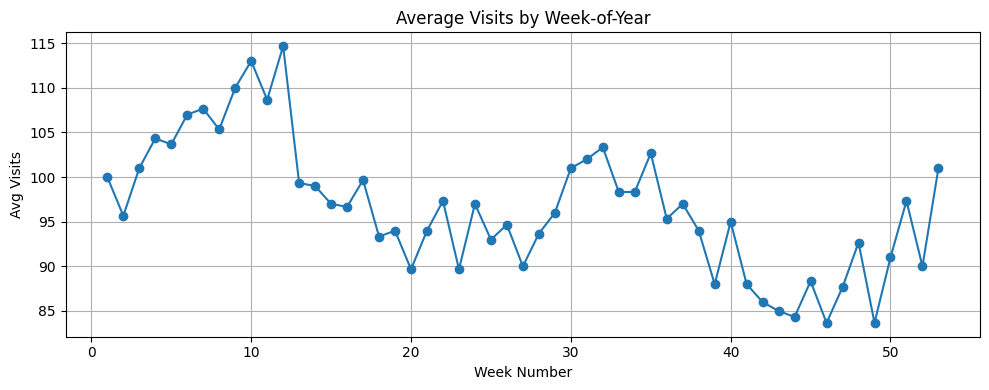

In [36]:
# 3.4 Avg by Week-of-Year
df["WeekOfYear"] = df.index.isocalendar().week
avg_week = df.groupby("WeekOfYear")["Patient_Visits"].mean()
plt.figure(figsize=(10,4))
plt.plot(avg_week.index, avg_week.values, marker="o")
plt.title("Average Visits by Week-of-Year")
plt.xlabel("Week Number"); plt.ylabel("Avg Visits"); plt.grid(True)
show_plot()

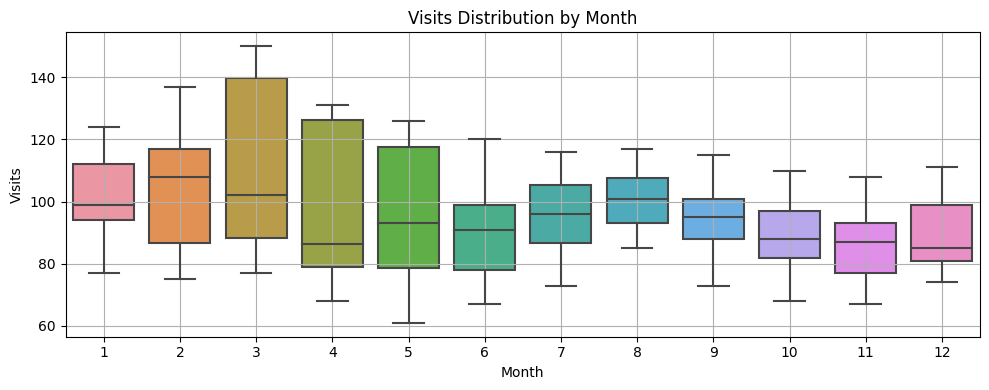

In [37]:
# 3.5 Boxplot by Month
df["Month"] = df.index.month
plt.figure(figsize=(10,4))
sns.boxplot(x="Month", y="Patient_Visits", data=df)
plt.title("Visits Distribution by Month")
plt.xlabel("Month"); plt.ylabel("Visits"); plt.grid(True)
show_plot()

In [38]:
# =============================================================================
# 4. Train/Test Split
# =============================================================================
train, test = ts[:-12], ts[-12:]
print(f"Train size: {len(train)}, Test size: {len(test)}\n")

X_train = np.arange(len(train)).reshape(-1,1)
X_test  = np.arange(len(train), len(train)+12).reshape(-1,1)


Train size: 144, Test size: 12



In [39]:
# =============================================================================
# 5. Metrics Helper
# =============================================================================
def compute_metrics(actual, predicted):
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mae  = mean_absolute_error(actual, predicted)
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    return rmse, mae, mape

In [40]:
# =============================================================================
# 6. Fit Models & Forecast
# =============================================================================
results = {}

# 6.1 Holt-Winters
hw = ExponentialSmoothing(train, trend="add", seasonal="add", seasonal_periods=52).fit()
results["Holt-Winters"] = hw.forecast(12)

# 6.2 ARIMA
arima = ARIMA(train, order=(2,1,2)).fit()
results["ARIMA(2,1,2)"] = arima.forecast(12)

# 6.3 SARIMA
sarima = SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,52),
                enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
results["SARIMA(1,1,1)(1,1,1,52)"] = sarima.forecast(12)

# 6.4 Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42).fit(X_train, train)
results["RandomForest"] = pd.Series(rf.predict(X_test), index=test.index)

# 6.5 Gradient Boosting
gb = GradientBoostingRegressor(n_estimators=100, random_state=42).fit(X_train, train)
results["GradientBoosting"] = pd.Series(gb.predict(X_test), index=test.index)

# 6.6 XGBoost
if xgb_available:
    xgb = XGBRegressor(n_estimators=100, random_state=42).fit(X_train, train)
    results["XGBoost"] = pd.Series(xgb.predict(X_test), index=test.index)

# 6.7 Linear Regression
lr = LinearRegression().fit(X_train, train)
results["LinearRegression"] = pd.Series(lr.predict(X_test), index=test.index)

# 6.8 Support Vector Regressor (SVR)
svr = SVR(kernel="rbf").fit(X_train, train)
results["SVR"] = pd.Series(svr.predict(X_test), index=test.index)

# 6.9 K-Nearest Neighbors (KNN) Regressor
knn = KNeighborsRegressor(n_neighbors=5).fit(X_train, train)
results["KNN"] = pd.Series(knn.predict(X_test), index=test.index)

# 6.10 Decision Tree Regressor
dt = DecisionTreeRegressor(random_state=42).fit(X_train, train)
results["DecisionTree"] = pd.Series(dt.predict(X_test), index=test.index)

# 6.11 AdaBoost Regressor
ab = AdaBoostRegressor(n_estimators=100, random_state=42).fit(X_train, train)
results["AdaBoost"] = pd.Series(ab.predict(X_test), index=test.index)


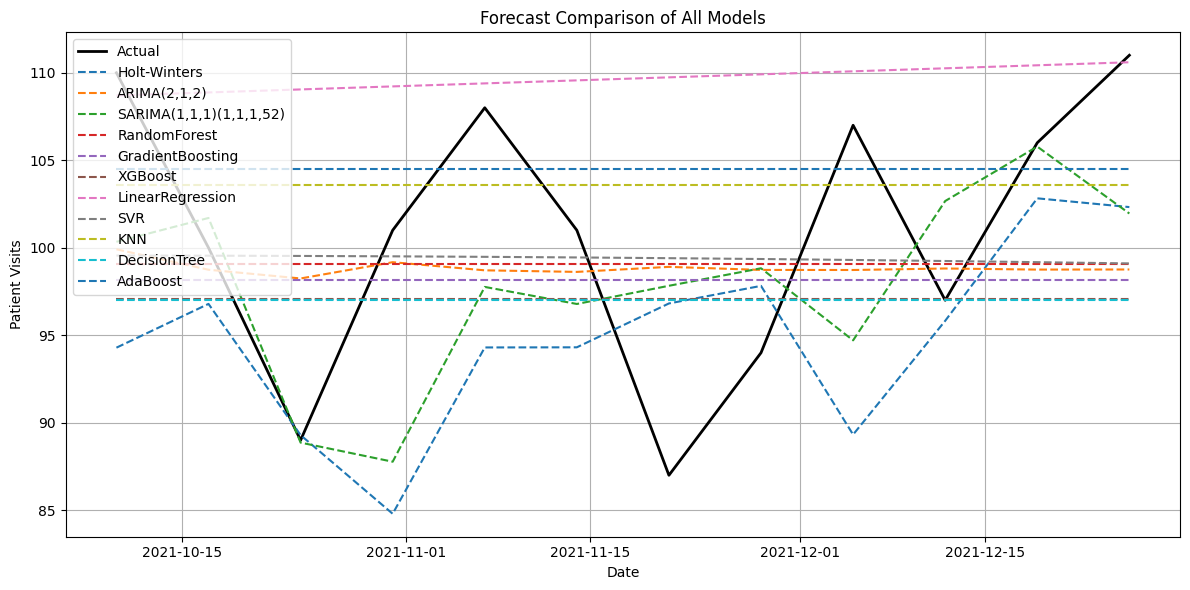

In [41]:

# =============================================================================
# 7. Forecast Comparison Plot
# =============================================================================
plt.figure(figsize=(12,6))
plt.plot(test.index, test, label="Actual", color="black", linewidth=2)
for model_name, pred in results.items():
    plt.plot(test.index, pred, "--", label=model_name)
plt.title("Forecast Comparison of All Models")
plt.xlabel("Date"); plt.ylabel("Patient Visits"); plt.legend(loc="upper left"); plt.grid(True)
show_plot()

In [44]:

# =============================================================================
# 8. Compute & Display Accuracy Metrics
# =============================================================================
metrics_df = pd.DataFrame(columns=["Model","RMSE","MAE","MAPE"])
for model_name, pred in results.items():
    rmse, mae, mape = compute_metrics(test, pred)
    new_row = pd.DataFrame({
        "Model": [model_name],
        "RMSE": [rmse],
        "MAE": [mae],
        "MAPE": [mape]
    })
    metrics_df = pd.concat([metrics_df, new_row], ignore_index=True)

metrics_df = metrics_df.sort_values("RMSE").reset_index(drop=True)
print(" Forecast Accuracy Metrics:\n")
print(metrics_df.to_string(index=False, float_format="%.2f"), "\n")

best_model = metrics_df.iloc[0]["Model"]
print(f" Recommended model: {best_model} (lowest RMSE)")

 Forecast Accuracy Metrics:

                  Model  RMSE  MAE  MAPE
           ARIMA(2,1,2)  7.76 6.69  6.65
                    SVR  7.81 6.62  6.61
           RandomForest  7.84 6.73  6.70
                    KNN  8.08 6.68  6.94
       GradientBoosting  8.11 7.03  6.94
SARIMA(1,1,1)(1,1,1,52)  8.16 6.84  6.72
               AdaBoost  8.43 6.83  7.14
                XGBoost  8.53 7.39  7.23
           DecisionTree  8.57 7.42  7.25
           Holt-Winters 10.26 8.35  8.09
       LinearRegression 11.55 9.02  9.55 

 Recommended model: ARIMA(2,1,2) (lowest RMSE)
